In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import re, string
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import praw
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json 
import math

# set seaborn settings
sns.set()
plt.rcParams["patch.force_edgecolor"] = True # set lines
plt.style.use('seaborn-darkgrid')


import warnings
warnings.filterwarnings('ignore')

# import credentials and helper functions
import credentials as creds
import helpers as h

C:\Users\Jacky Zhao\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# API AND LIBRARY DOCUMENTATIONS:
# https://praw.readthedocs.io/en/latest/getting_started/
# https://www.reddit.com/dev/api/

## Instantiate Reddit

In [3]:
CLIENT_ID = creds.client_id()
CLIENT_SECRET_KEY = creds.client_secret_key()


r = praw.Reddit(client_id = CLIENT_ID,
                client_secret = CLIENT_SECRET_KEY,
                user_agent = 'RedditorMatch')

## Specify the scraped datasets

Unfortunately, it takes quite some time to retrieve user comments from a particular subreddit. Remember, we're going into a specified subreddit, finding a list of users who posted, and then scraping out every single comment that those users made in the past. In order to remove this bottleneck from my demonstration, I have scraped the comments from users who have posted on r/mizzou. 

In [4]:
scraped_subreddits = ["mizzou"]

## Recommendation engine logic

* ***find_similar():*** Takes in the TFIDF matrix (matrix), the index of the document that you want to match against (index), and the number of results to be displayed (top_n / optional). 6 is chosen as the default for top_n because we're really only interested in the top 5 matched redditors. However, your own username might be chosen as well because well....your comments are very similar to your own comments and thus would have the highest score. The similarity is calculated using the cosine similarity.

* ***getDf():*** Takes in the string of the subreddit name and retrieves the scraped comments from the appropriate csv file. 

* ***stem():*** Takes in a corpus and returns a stemmed corpus. It first tokenizes and stems each word before putting it back together as a single document. 

* ***findMatches():*** Takes in your username (string), subreddit name (string), and reddit API instance. It calls getDf() to retrieve the scraped comments and applies it to a corpus of comments. It then calls one of the helper functions that I wrote (getUserComments()) to gather the comments of the input username and then prepends it onto the corpus array. It then builds the TFIDF vectorizer with the n_gram specificity of 1 to 3 words. In addition, I'm adding more stopwords into the mix. Once we fit and transform the corpus to get the matrix, we call "find_similar()" to retrieve the top 5 matched usernames. 

In [5]:
def find_similar(matrix, index, top_n = 6):
    cosine_similarities = linear_kernel(matrix[index: index + 1], matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [6]:
def getDf(subreddit_name):
    filePath = "data/" + subreddit_name + ".csv"
    df = pd.read_csv(filePath, encoding = "ISO-8859-1")
    print("--- Retrieved", len(df), "corpuses/corpi(?) for", subreddit_name)
    return(df)

In [7]:
def stem(corpus):
    newCorpus = []
    print("------ Stemming the words")
    
    stemmer = PorterStemmer()
    
    for c in corpus:
        try:
            tokens = nltk.word_tokenize(c)
            
            new_tokens = []
            
            for t in tokens:
                try:
                    new_t = stemmer.stem(t)
                    new_tokens.append(new_t)          
                except:
                    print("can't stem the word. moving on...")

            new_c = ' '.join(new_tokens)
            newCorpus.append(new_c)
                
        except:
            print("skipping the comment. something went wrong...")
        
    return(newCorpus)

In [8]:
def findMatches(your_username, subreddit_name, redditInstance):
    corpus = []    
    corpusDf = getDf(subreddit_name)
    corpusDf["Comments"].apply(lambda row: corpus.append(str(row)))
    
    corpus = stem(corpus)
    
    your_comments = h.getUserComments(your_username, redditInstance)
    your_comments = stem(your_comments)    
    your_comments = " ".join(your_comments)
    
    corpus.insert(0, your_comments)
    
    print("--- Creating Tfidf vector...")
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    tf = TfidfVectorizer(analyzer = "word", 
                            ngram_range = (1, 3),
                            min_df = 0, 
                            stop_words = myStopWords)
    
    print("--- Fitting the matrix...")
    matrix = tf.fit_transform(corpus)
    results = []
    
    for index, score in find_similar(matrix, 0):        
        index = index - 1 # because we prepended our comments onto the corpus, the index number was shifted by 1.
        user = corpusDf.iloc[index, 0]
        results.append(user)
        print("...")
        print("...")
        print("Score:", score, "| Username:", user)
        print("=========================================================")
        
    return(results)

### Example:

In [9]:
# NOTE: I'm displaying the top 6 usernames who are similar. 
# I chose 6 because if the username is contained in my scraped dataset, 
# then that username will always show up as most similar. 
# But we really only care about the top 5 usernames. 

matches = findMatches("Max_W_", scraped_subreddits[0], r)

--- Retrieved 288 corpuses/corpi(?) for mizzou
--------- stemming the corpus
------ Retrieved 1875 comments for: Max_W_
--------- stemming the corpus
--- Creating Tfidf vector...
--- Fitting the matrix...
...
...
Score: 0.969225369472 | Username: Max_W_
...
...
Score: 0.393624902539 | Username: PrancingPeach
...
...
Score: 0.390623113213 | Username: SexyMcBeast
...
...
Score: 0.389878832463 | Username: BrettGilpin
...
...
Score: 0.378070693475 | Username: KCTigerGrad
...
...
Score: 0.371771697758 | Username: YouKnowThatOtherGuy


## Gather user information

In [10]:
def getRedditorInfo(redditor_name, r):
    user = r.redditor(redditor_name)
    top = user.comments.top(limit = 1000)
    hot = user.comments.hot(limit = 1000)
    contro = user.comments.controversial(limit = 1000)
    
    subreddit = []
    comment = []
    created_utc = []
    score = []
    ups = []
    downs = []
    controversiality = []
    flair = []
    gilded = []
    over_18 = []
    link = []
    
    for c in top:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in hot:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in contro:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    df = pd.DataFrame(subreddit, columns = ["subreddit"])
    df["comment"] = comment
    df["created_utc"] = created_utc
    df["score"] = score
    df["ups"] = ups
    df["downs"] = downs
    df["controversiality"] = controversiality
    df["flair"] = flair
    df["gilded"] = gilded
    df["over_18"] = over_18
    df["link"] = link
    
    df = df.drop_duplicates(subset = ["comment"], keep = "first")    
    print("Retrieved", len(df), "comments for user:", redditor_name)
    return(df)

### Examples

In [11]:
comments1 = getRedditorInfo("Max_W_", r)
comments2 = getRedditorInfo("PrancingPeach", r)

Retrieved 2422 comments for user: Max_W_
Retrieved 2734 comments for user: PrancingPeach


In [12]:
comments1.head()

,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link
0,r/EnoughTrumpSpam,Can we start a petition to keep them private,2017-05-20 02:22:38,8572,8572,0,0,None,1,False,https://www.reddit.com/r/EnoughTrumpSpam/comme...
1,r/AskReddit,Two down one to go,2018-03-09 05:00:25,5551,5551,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/83...
2,r/cringe,Lets applaud her dancers They continued on lik...,2017-01-01 05:24:43,3845,3845,0,0,None,0,False,https://www.reddit.com/r/cringe/comments/5ldm3...
3,r/AskReddit,What do you do when you come across an elephan...,2018-03-09 02:49:12,1963,1963,0,0,None,0,True,https://www.reddit.com/r/AskReddit/comments/83...
4,r/LivestreamFail,She threatened nuclear war with North Korea,2017-11-03 03:50:02,1762,1762,0,0,None,0,False,https://www.reddit.com/r/LivestreamFail/commen...


## Find common subreddits between 2 users

In [13]:
def commonSubreddits(user1, user2, redditInstance):
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)
            
    df2 = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)
            
    df1 = df1.merge(df2, on = "subreddit", how = "inner")["subreddit"]
    result = np.array(df1)
    
    return(result)

In [14]:
def commonSubredditCounts(user1, user2, redditInstance):
    
    common = commonSubreddits(user1, user2, redditInstance)  
    print(len(common), "common subreddits found...")
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1[df1["subreddit"].isin(common)]
    df2 = df2[df2["subreddit"].isin(common)]
        
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    df2Counts = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)\
            .reset_index(drop = True)      
            
    renameCols = ["id", "value"]
            
    df1Counts.columns = renameCols
    df2Counts.columns = renameCols
    
    df1Counts["id"] = df1Counts["id"].str.lower()
    df2Counts["id"] = df2Counts["id"].str.lower()
    
    df1Counts["id"] = df1Counts["id"].str.replace("r/", "")
    df2Counts["id"] = df2Counts["id"].str.replace("r/", "")
    
    df1Counts = df1Counts.sort_values(by = ["id"], ascending = True)
    df2Counts = df2Counts.sort_values(by = ["id"], ascending = True)    
    
                
    return(df1Counts, df2Counts)

In [15]:
def subredditCounts(user, redditInstance):
    df1 = getRedditorInfo(user, redditInstance)
    
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    renameCols = ["id", "value"]
    df1Counts.columns = renameCols
    df1Counts["id"] = df1Counts["id"].str.lower()
    df1Counts["id"] = df1Counts["id"].str.replace("r/", "")
    df1Counts = df1Counts.sort_values(by = ["id"], ascending = True)   
    
    return(df1Counts)  

In [16]:
allSubreddits1 = subredditCounts("Max_W_", r)
allSubreddits2 = subredditCounts("PrancingPeach", r)

# Output to CSV files for visualization. 
allSubreddits1.to_csv("frontend/all_sub1.csv", index = False)
allSubreddits2.to_csv("frontend/all_sub2.csv", index = False)

Retrieved 2422 comments for user: Max_W_
Retrieved 2734 comments for user: PrancingPeach


### Examples

In [17]:
one, two = commonSubredditCounts("Max_W_", "PrancingPeach", r)

# Output to CSV files for visualization. 
one.to_csv("frontend/common_sub1.csv", index = False)
two.to_csv("frontend/common_sub2.csv", index = False)

Retrieved 2422 comments for user: Max_W_
Retrieved 2734 comments for user: PrancingPeach
39 common subreddits found...
Retrieved 2422 comments for user: Max_W_
Retrieved 2734 comments for user: PrancingPeach


In [18]:
one.head(100)

,id,value
8,adviceanimals,31
2,android,64
0,askreddit,384
26,atheism,2
16,aww,5
36,creepy,1
21,cringe,2
25,cringepics,2
18,dataisbeautiful,3
3,enoughtrumpspam,47


In [19]:
two.head(100)

,id,value
16,adviceanimals,10
23,android,3
4,askreddit,53
18,atheism,9
25,aww,2
28,creepy,1
7,cringe,38
38,cringepics,1
9,dataisbeautiful,29
10,enoughtrumpspam,24


## Get user flairs

In [20]:
def getFlairs(username, redditInstance):
    df = getRedditorInfo(username, redditInstance)
    flairs = set(np.unique(np.array((df[(df["flair"].isnull() == False) & (df["flair"] != "")]["flair"]))))
    if (len(flairs) < 1):
        print("No flairs for this user")
        return None
    else:
        return(flairs)

In [21]:
getFlairs("Max_W_", r)

Retrieved 2422 comments for user: Max_W_


{'Chiefs',
 'Honor 7X / Asus Nexus 7 / Moto e4+ ',
 'Honor 7X, Blue',
 'Kansas City Royals',
 'MaxW // Force Sensitive',
 'Missouri',
 'Nexus7 FHD',
 'Royals are clutch!'}

In [22]:
getFlairs("PrancingPeach", r)

Retrieved 2734 comments for user: PrancingPeach


{'1∆'}

## Find top features

In [23]:
def top_tfidf_feats(row, features, top_n = 50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [24]:
def top_feats_in_doc(Xtr, features, row_id, top_n = 50):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [25]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=50):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [26]:
def getTopFeatures(your_username, redditInstance):
    
    your_corpus = h.getUserComments(your_username, redditInstance)  
    converted_corpus = []
    
    stemmer = PorterStemmer()
    
    for c in your_corpus:        
        tokens = nltk.word_tokenize(c)
        new_c = ' '.join(stemmer.stem(t) for t in tokens) 
        converted_corpus.append(new_c)
    
    your_corpus = converted_corpus   
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    tf1 = TfidfVectorizer(analyzer = "word", 
                        ngram_range = (1, 3),
                        min_df = 0, 
                        stop_words = myStopWords)  
    
    matrix1 = tf1.fit_transform(your_corpus)
    features1 = tf1.get_feature_names()         
    yourTopOverallFeatures = top_mean_feats(matrix1, features1)
    cols = ["id", "value"]
    yourTopOverallFeatures.columns = cols
        
    return(yourTopOverallFeatures)

### Example

In [27]:
top = getTopFeatures("Max_W_", r)

top.to_csv("frontend/topFeatures.csv", index = False)

top.head()

------ Retrieved 1875 comments for: Max_W_


,id,value
0,wa,0.007712
1,thi,0.007707
2,like,0.006776
3,good,0.006581
4,look,0.005261


## Find subreddits that a user posts in

In [28]:
def getSubredditsPosted(username, redditInstance):
    comments = getRedditorInfo(username, redditInstance)
    subs = np.array(comments["subreddit"])
    subs = (np.unique(subs))
    return(subs)

In [29]:
getSubredditsPosted("Max_W_", r)

Retrieved 2422 comments for user: Max_W_


array(['r/ActLikeYouBelong', 'r/AdviceAnimals', 'r/AmIFreeToGo',
       'r/Android', 'r/AndroidQuestions', 'r/AnythingGoesPics', 'r/AskMen',
       'r/AskReddit', 'r/BacktotheFuture', 'r/Bad_Cop_No_Donut',
       'r/BannedFromThe_Donald', 'r/BeAmazed', 'r/Blackout2015',
       'r/BravesGIFs', 'r/BuyItForLife', 'r/C25K', 'r/CFB',
       'r/CatsStandingUp', 'r/Celebs', 'r/Chromecast', 'r/Cinemagraphs',
       'r/Cloververse', 'r/ColorizedHistory', 'r/Cyberpunk',
       'r/DC_Cinematic', 'r/DiWHY', 'r/EnoughTrumpSpam',
       'r/ExpectationVsReality', 'r/Eyeshakers', 'r/Fitness', 'r/Frugal',
       'r/Frugal_Jerk', 'r/Fullmoviesonvimeo', 'r/GalGadot',
       'r/GetMotivated', 'r/GradSchool', 'r/HadToHurt',
       'r/HighQualityGifs', 'r/Honor', 'r/Honor8', 'r/Huawei',
       'r/HumansBeingBros', 'r/IAmA', 'r/IDontWorkHereLady',
       'r/IdiotsFightingThings', 'r/IdiotsInCars',
       'r/ImGoingToHellForThis', 'r/Jokes', 'r/JusticePorn', 'r/KCRoyals',
       'r/KansasCityChiefs', 'r/LateS

## Analyze sentiment of user comments

In [30]:
def getSentiment(username, r):
    comments = getRedditorInfo(username, r)
                    
    if (len(comments) < 1):
        print("No comments for that user")
        return None
                        
    comments = comments.sort_values("created_utc", ascending = True)    
    sid = SentimentIntensityAnalyzer()
    
    comments["negative"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neg"]) 
    comments["neutral"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neu"]) 
    comments["positive"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["pos"]) 
    comments["compound"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["compound"]) 
    
    return(comments)    

### Examples

In [31]:
sents = getSentiment("Max_W_", r)
sents.head()

Retrieved 2422 comments for user: Max_W_


,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link,negative,neutral,positive,compound
2418,r/pics,Thats just his pay and doesnt include other bo...,2011-10-06 18:46:47,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/l39co/i...,0.199,0.801,0.000,-0.6894
66,r/AskReddit,I upvoted for karma but I think you already go...,2011-10-14 14:22:20,95,95,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/lb...,0.000,1.000,0.000,0.0000
2417,r/pics,Thats odd suddenly at work I got a crick in my...,2011-10-19 18:13:18,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/lhpzc/w...,0.204,0.796,0.000,-0.3182
2416,r/AskReddit,Do yourself a favor and check out BAND OF BROT...,2011-10-24 19:37:39,1,1,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/ln...,0.000,0.856,0.144,0.4019
2593,r/mizzou,Seems relevanthttp memegeneratornetcacheinstan...,2011-10-24 21:37:51,4,4,0,0,None,0,False,https://www.reddit.com/r/mizzou/comments/lnigs...,0.000,1.000,0.000,0.0000


## Plot sentiment of comments over time

In [32]:
def plotSentiment(username, subreddit_name, redditInstance):
    sents = getSentiment(username, redditInstance)
    subreddit_name = "r/" + subreddit_name
    sents = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]
    sents = sents.sort_values("created_utc", ascending = True)  
    sents = sents.reset_index()
    sents["id"] = sents.index
    
    if (len(sents) < 3):
        print("User has not posted on this subreddit")
        return        
        
    _ = plt.plot(sents["id"], sents["compound"], marker = "", linewidth = 1.9, alpha = 0.9)
    title = "Sentiment analysis on " + subreddit_name + " for user: " + username
    _ = plt.suptitle(title)
    _ = plt.show()
    
    return

In [33]:
def plotTopSentiments(username, redditInstance):
    sents = getSentiment(username, redditInstance)    
   
    subreddits = np.array(sents.groupby(["subreddit"]).\
                                                  count().\
                                                  reset_index().\
                                                  sort_values("comment", ascending = False).\
                                                  head(4)["subreddit"])
    
    numberOfSubs = len(subreddits)
    
    # create a color palette
    palette = plt.get_cmap('Set1')
    num = 0
    
    for s in subreddits:       
        
        subreddit_name = s
        df = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]       
        
        if (len(df) >= 2):            
            num = num + 1 

            # Find the right spot on the plot
            _ = plt.subplot(2, 2, num)                 

            df = df.sort_values("created_utc", ascending = True)  
            df = df.reset_index()
            df["id"] = df.index

            _ = plt.plot(df["id"], df["compound"], marker = "", linewidth = 1.9, alpha = 0.9, color = palette(num))

            # Not ticks everywhere
            if num in range(7) :
                _ = plt.tick_params(labelbottom='off')
            if num not in [1,4,7] :
                _ = plt.tick_params(labelleft='off')

            # Add title
            _ = plt.title(subreddit_name, loc='left', fontsize=12, fontweight=0, color=palette(num))
             

    title = "Sentiment analysis " + "for user: " + username
    _ = plt.suptitle(title, fontsize=13, fontweight=0, color='black', style='italic', y=1.02)    
    _ = plt.show()
    
    return

### Examples

Retrieved 2422 comments for user: Max_W_


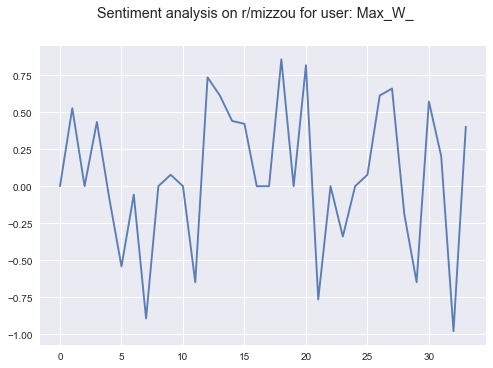

In [34]:
plotSentiment("Max_W_", "mizzou", r)

Retrieved 2422 comments for user: Max_W_


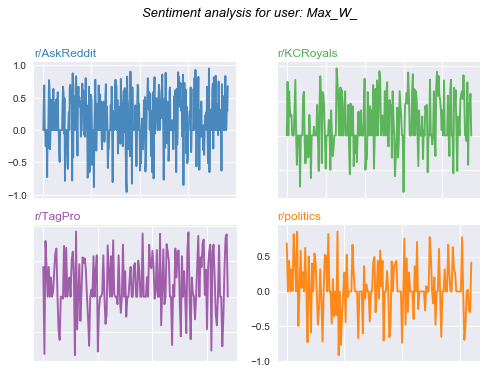

In [35]:
plotTopSentiments("Max_W_", r)

In [ ]:
plotTopSentiments("ohai123456789", r)

In [4]:
# NOTE: plot a cumulative chart of sentiment

## Build collapsible index visualization

In [38]:
def formatToDict(name, size):    
    return {'name': name, 'size': round(size*100000)}

In [39]:
def buildCollapsible(your_username, subreddit_name, redditInstance):
    matches = list(findMatches(your_username, subreddit_name, redditInstance))
    
    if (len(matches) < 1): 
        return None
    
    entireObjDict = {}
    entireObjDict["name"] = "Top Features"
    objList = []
    
    for username in matches:
        colNames = ["name", "size"]
        features = getTopFeatures(username, redditInstance)        
        features.columns = colNames
        features = features.head(15)
        
        children = list(features.apply(lambda row: formatToDict(row["name"], row["size"]), axis = 1))
        children
        
        userObj = {}
        userObj["name"] = username
        userObj["children"] = children
        objList.append(userObj)
        
    entireObjDict["children"] = objList        
    return(entireObjDict)        

In [40]:
jsonObj = buildCollapsible("Max_W_", "mizzou", r)

--- Retrieved 288 corpuses/corpi(?) for mizzou
--------- stemming the corpus
------ Retrieved 1875 comments for: Max_W_
--------- stemming the corpus
--- Creating Tfidf vector...
--- Fitting the matrix...
...
...
Score: 0.969225369472 | Username: Max_W_
...
...
Score: 0.393624902539 | Username: PrancingPeach
...
...
Score: 0.390623113213 | Username: SexyMcBeast
...
...
Score: 0.389878832463 | Username: BrettGilpin
...
...
Score: 0.378070693475 | Username: KCTigerGrad
...
...
Score: 0.371771697758 | Username: YouKnowThatOtherGuy
------ Retrieved 1875 comments for: Max_W_
------ Retrieved 1931 comments for: PrancingPeach
------ Retrieved 1835 comments for: SexyMcBeast
------ Retrieved 1958 comments for: BrettGilpin
------ Retrieved 983 comments for: KCTigerGrad
------ Retrieved 1861 comments for: YouKnowThatOtherGuy


## K-means clustering